# **Imports**

In [2]:
from io import IncrementalNewlineDecoder
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
from statistics import mean, stdev
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [3]:
import config
import utils
from Replay import ReplayBuffer, ExpertReplayBuffer
from Network import SoftQNetwork, SoftDQNAgent, QNetwork
from Agent import DQNAgentOurAlgo

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# **Gym Environment**

In [5]:
env = gym.make('LunarLander-v2')
env.reset(seed = 0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Training**

In [6]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
expertAgent = SoftDQNAgent(state_size, action_size, seed=0, algo = "ours")
expertAgent.q_network.load_state_dict(torch.load('./expert'))
expertAgent.q_network.eval()


SoftQNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

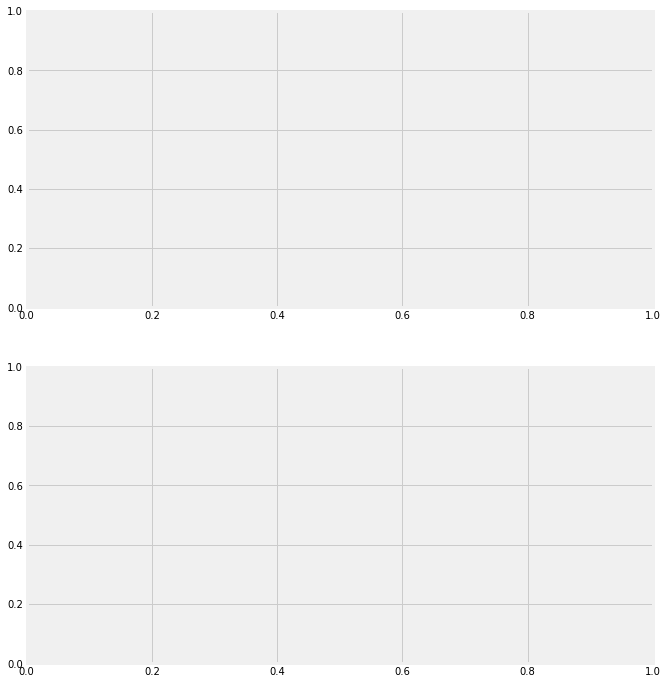

In [7]:
from IPython.core.pylabtools import figsize
from IPython.display import display, clear_output
fig, axs = plt.subplots(2,1, figsize=(10,12))
# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(2, 1, 1)
# dqn_agent.expertStore(expertAgent, env)
# ax[0]

In [10]:
%reload_ext autoreload
avg_scores = [] #stores the scores over all experiments
avg_std_window = [] #stores the standard deviations of the rolling window over all experiments
start = time()
STD_DECAY = 0.997
STD_MIN = 1
std_arr_called = []
for exp in range(5):
    dqn_agent = DQNAgentOurAlgo(state_size, action_size, seed=0)
    scores = []
    std_array = []
    std_eps_arr = []
    throwArr = []
    stdDecay = []
    
    # Maintain a list of last 100 scores
    scores_window = deque(maxlen=100)
    scores_window_std = deque(maxlen=50)
    eps = config.EPS_START
    stdThreshold = 35
    EXPERT_CALLED_EPISODE = 1
    for episode in range(1, config.MAX_EPISODES + 1):
        state = env.reset()
        score = 0
        for t in range(config.MAX_STEPS):
            action = dqn_agent.act(state, eps)
            next_state, reward, done,truncated, info = env.step(action)
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state        
            score += reward
            if done:
                break
                
            eps = max(eps* config.EPS_DECAY, config.EPS_MIN)
            if episode % config.PRINT_EVERY == 0:
                mean_score = np.mean(scores_window)
                print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="")
            
            if score >= config.ENV_SOLVED:
                mean_score = np.mean(scores_window)
                print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
                sys.stdout.flush()
                dqn_agent.checkpoint('solved_OurAlg.pth')
                break
    
        stdThreshold = max(stdThreshold* STD_DECAY, STD_MIN)
        stdDecay.append(stdThreshold)

        #storing scores for plotting later
        scores_window.append(score) 
        scores.append(score)

        #storing std array for kids
        scores_window_std.append(np.mean(scores_window))
        std_array.append(np.std(scores_window_std , dtype=np.float32))

        throwArr.append(len(dqn_agent.expertMemory))

        #plotting real time graph
        axs[0].set_xlim(0,episode)
        axs[0].cla()
        axs[0].plot(scores)
        axs[0].plot(pd.Series(scores).rolling(100).mean())
        axs[0].set_title('Experiment number ' + str(exp+1)+ ' for Our Alg')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)

    std_arr_called.append(std_eps_arr)
    avg_std_window.append(std_array)
    avg_scores.append(scores)
    del dqn_agent
    
end = time()    
print('Took {} seconds'.format(end - start))

Took 15338.326075553894 seconds


In [18]:
textfile = open("OurAlgNoExpScores.txt", "w")
textfile.write(str(avg_scores))
textfile.close()

textfile = open("OurAlgNoExpStd.txt", "w")
textfile.write(str(avg_std_window))
textfile.close()


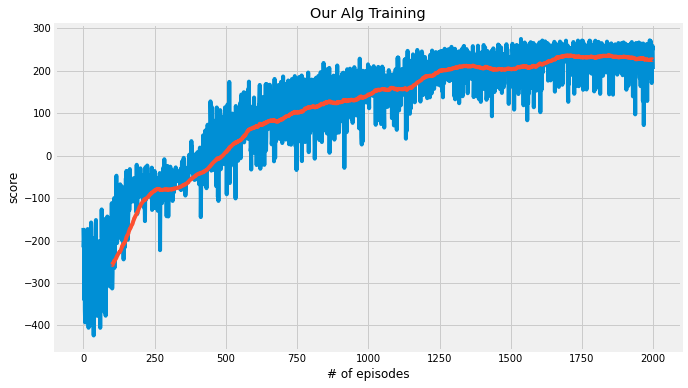

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(avg_scores, axis=0))
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('Our Alg Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [6]:
with open("BenchmarkScores.txt", "r") as f:
    bobs = []

    for lines in f:
        lines = lines[1:-1].split("[")

        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs.append(arr)

with open("ogDQNScores.txt", "r") as f:
    bobs2 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs2.append(arr)

with open("OurAlgScores.txt", "r") as f:
    bobs3 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs3.append(arr)

with open("OurAlgNoExpScores.txt", "r") as f:
    bobs4 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs4.append(arr)

# bobs = utils.importTxt("BenchmarkScores.txt")
# bobs2 = utils.importTxt("ogDQNScores.txt")
# bobs3 = utils.importTxt("OurAlgScores.txt")
# bobs4 = utils.importTxt("OurAlgNoExpScores.txt")

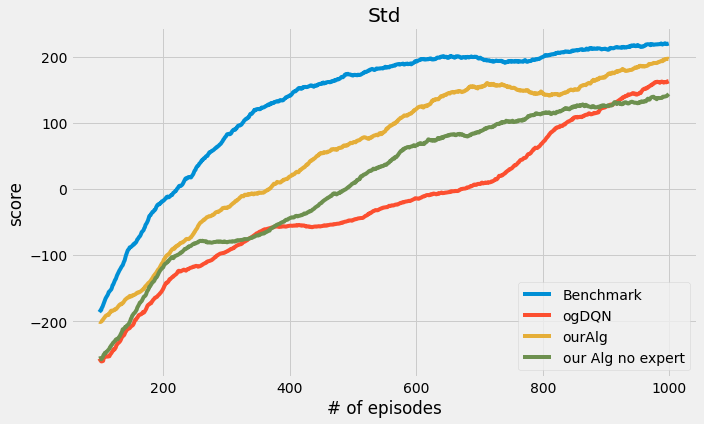

In [7]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0))[:1000].rolling(100).mean(), label='Benchmark')
plt.plot(pd.Series(np.mean(bobs2, axis=0))[:1000].rolling(100).mean(), label='ogDQN')
plt.plot(pd.Series(np.mean(bobs3, axis=0))[:1000].rolling(100).mean(), label='ourAlg')
plt.plot(pd.Series(np.mean(bobs4, axis=0))[:1000].rolling(100).mean(), label ='our Alg no expert')
# plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('Std')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.legend()
plt.show()

In [ ]:
%reload_ext autoreload
dqn_agent = DQNAgentOurAlgo(state_size, action_size, seed=0)
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
mean_scores_window = deque(maxlen=50)
eps = config.EPS_START
EXPERT_CALLED_EPISODE = 1
for episode in range(1, config.MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(config.MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * config.EPS_DECAY, config.EPS_MIN)
        if episode % config.PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            # print('std of rolling window is:', np.std(mean_scores_window , dtype=np.float32),'\n')
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="\n")
        if episode >= 100 and np.std(mean_scores_window , dtype=np.float32) <= config.STD_THRESHOLD and (episode - EXPERT_CALLED_EPISODE) >=30 :
            EXPERT_CALLED_EPISODE = episode
            print('The std of the rolling window has fallen to: ', np.std(mean_scores_window , dtype=np.float32))
            dqn_agent._call_expert_KL(expertAgent, env, config.MAX_EXPERT_EPISODES)
        if score >= config.ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_OurAlg.pth')
            break
            
    scores_window.append(score)
    mean_scores_window.append(np.mean(scores_window))
    scores.append(score)
    ax.set_xlim(0,episode)
    ax.cla()
    ax.plot(scores)
    ax.plot(pd.Series(scores).rolling(100).mean())
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)
    
end = time()    
print('Took {} seconds'.format(end - start))

Took 2175.981738805771 seconds


In [ ]:
dqn_agent.checkpoint('solved_OurAlg.pth')
torch.save(dqn_agent.q_network.state_dict(),'./ourAlg')

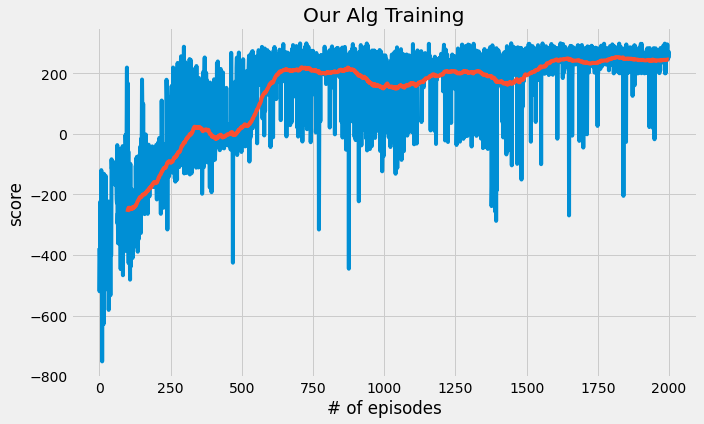

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('Our Alg Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [ ]:
with open("BenchmarkStd.txt", "r") as f:
    bobs = []

    for lines in f:
        lines = lines[1:-1].split("[")

        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs.append(arr)

with open("ogDQNStd.txt", "r") as f:
    bobs2 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs2.append(arr)

In [ ]:
bobs3 = [ 35*(0.997**i) for i in range(2000)]

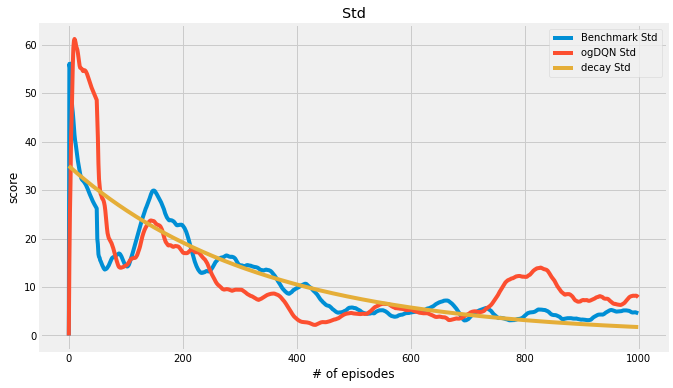

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(bobs, axis=0)[:1000], label='Benchmark Std')
plt.plot(np.mean(bobs2, axis=0)[:1000], label='ogDQN Std')
plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('Std')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.legend()
plt.show()